In [46]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [47]:
ms_df=pd.read_csv('Microsoft_Data.csv')## Reading Dataset

cat_cols=[col for col in ms_df.columns if ms_df[col].dtype=='object'] 
cont_cols=[col for col in ms_df.columns if ms_df[col].dtype=='int64' or ms_df[col].dtype=='float64']


In [48]:
corr_cols_df=ms_df.copy()##creating copy of DF for correlated columns and using this DFrame
corr_cat_cols=[col for col in corr_cols_df.columns if corr_cols_df[col].dtype=='object'] 
corr_cont_cols=[col for col in corr_cols_df.columns if corr_cols_df[col].dtype=='int64' or corr_cols_df[col].dtype=='float64']

In [49]:
for col in corr_cont_cols:###Relacing MIss values with mean for total column just to avoid nan in finding p_values
    corr_cols_df[col].fillna(corr_cols_df[col].mean(),inplace=True)
for col in corr_cat_cols:
    corr_cols_df[col].fillna(corr_cols_df[col].mode(),inplace=True)


In [50]:
def ch_sqr(col):#### Chi square Logic
    contigency_table=pd.crosstab(corr_cols_df[col],corr_cols_df['HasDetections'])
    res=chi2_contingency(contigency_table)
    return res[1],col

data=[ch_sqr(col) for col in corr_cat_cols]

cat_chi_sq_df=pd.DataFrame(data,columns =['p_value', 'col_name'])
corr_catg_cols=cat_chi_sq_df[cat_chi_sq_df['p_value'] < 0.05]
corr_catg_col_names=list(corr_catg_cols['col_name']) # Correlated catg columns


In [51]:
catg=corr_cols_df['HasDetections'].value_counts().index.tolist()

def anova(col):### Anova logic
    res=f_oneway(*[corr_cols_df[corr_cols_df['HasDetections']==cat][col]for cat in catg])
    return res[1],col

cont_data=[anova(col) for col in corr_cont_cols]
cont_data

cont_anova_df=pd.DataFrame(cont_data,columns =['value', 'col_name'])
#cont_anova_df['value']=cont_anova_df['value'].fillna(0)
#cont_anova_df


In [52]:
corr_cont_cols=cont_anova_df[cont_anova_df['value'] < 0.05]
corr_cont_col_names=list(corr_cont_cols['col_name'])
len(corr_cont_col_names)## correlated cont columns

36

In [53]:
len(corr_catg_col_names)## correlated catg cols

24

In [54]:
tot_corr_col_names=corr_catg_col_names + corr_cont_col_names
#tot_corr_col_names## Total correlated columns

In [55]:
#list(np.intersect1d(ms_df_cols, tot_corr_col_names))
mainfo_df=ms_df.copy()## Creating copy of DF for deleting unwanted columns
mainfo_df.drop(columns=tot_corr_col_names,inplace=True)## Now this DF contains unwanted columns so that it can pass to next step
ls_cols_remove=list(mainfo_df.columns)


In [56]:
ms_df.drop(columns=ls_cols_remove,inplace=True) ## Unwanted cols deleting and having only correlated cols
ms_df## only Correlated cols in main DF

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,GeoNameIdentifier,...,Census_GenuineStateName,Census_ActivationChannel,Census_FirmwareManufacturerIdentifier,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7.0,0,53447.0,1.0,1.0,29,35.0,...,IS_GENUINE,Retail,628.0,0.0,0,0,0.0,0.0,10.0,0
1,1.1.14600.4,4.13.17134.1,1.263.48.0,7.0,0,53447.0,1.0,1.0,93,119.0,...,OFFLINE,Retail,628.0,0.0,0,0,0.0,0.0,8.0,0
2,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7.0,0,53447.0,1.0,1.0,86,64.0,...,IS_GENUINE,OEM:NONSLP,142.0,0.0,0,0,0.0,0.0,3.0,0
3,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7.0,0,53447.0,1.0,1.0,88,117.0,...,IS_GENUINE,OEM:NONSLP,355.0,0.0,0,0,0.0,0.0,3.0,1
4,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7.0,0,53447.0,1.0,1.0,18,277.0,...,IS_GENUINE,Retail,355.0,0.0,0,0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56751,1.1.15100.1,4.18.1807.18075,1.273.1056.0,7.0,0,53447.0,1.0,1.0,171,211.0,...,INVALID_LICENSE,Retail,556.0,0.0,0,0,0.0,1.0,3.0,0
56752,1.1.15100.1,4.18.1807.18075,1.273.689.0,7.0,0,41571.0,2.0,1.0,63,87.0,...,IS_GENUINE,OEM:DM,554.0,0.0,0,0,0.0,1.0,1.0,1
56753,1.1.15200.1,4.18.1807.18075,1.275.1454.0,7.0,0,53447.0,1.0,1.0,201,267.0,...,IS_GENUINE,Retail,142.0,0.0,0,0,0.0,1.0,11.0,0
56754,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7.0,0,43856.0,2.0,1.0,93,119.0,...,IS_GENUINE,Retail,559.0,0.0,0,0,0.0,0.0,8.0,1


In [57]:
y=ms_df['HasDetections']

ms_df.drop(columns=['HasDetections'],inplace=True)
y

0        0
1        0
2        0
3        1
4        1
        ..
56751    0
56752    1
56753    0
56754    1
56755    1
Name: HasDetections, Length: 56756, dtype: int64

In [58]:
df=pd.DataFrame({'col_name':ms_df.columns,'na_cnt':ms_df.isnull().sum(),'pc_cnt':(ms_df.isnull().sum()/ms_df.shape[0])*100})


col_gt50_ls=list(df[df['pc_cnt']>50]['col_name'])

ms_df.drop(columns=col_gt50_ls,inplace=True)

x_train,x_test,y_train,y_test=train_test_split(ms_df,y,random_state=99,test_size=0.2)

main_con_cols=[col for col in ms_df.columns if ms_df[col].dtype=='int64' or ms_df[col].dtype=='float64']
main_cat_cols=[col for col in ms_df.columns if ms_df[col].dtype=='object']

In [59]:
df

,col_name,na_cnt,pc_cnt
EngineVersion,EngineVersion,0,0.000000
AppVersion,AppVersion,0,0.000000
AvSigVersion,AvSigVersion,0,0.000000
RtpStateBitfield,RtpStateBitfield,196,0.345338
IsSxsPassiveMode,IsSxsPassiveMode,0,0.000000
AVProductStatesIdentifier,AVProductStatesIdentifier,222,0.391148
AVProductsInstalled,AVProductsInstalled,222,0.391148
AVProductsEnabled,AVProductsEnabled,222,0.391148
CountryIdentifier,CountryIdentifier,0,0.000000
GeoNameIdentifier,GeoNameIdentifier,1,0.001762


In [60]:
for col in main_con_cols:
    x_train[col].fillna(x_train[col].mean(),inplace=True)
    x_test[col].fillna(x_train[col].mean(),inplace=True)
    
for col in main_cat_cols:
    x_train[col].fillna(x_train[col].mode()[0],inplace=True)
    x_test[col].fillna(x_train[col].mode()[0],inplace=True)

In [61]:
scaler=StandardScaler()

for col in main_con_cols:
    x_train[col]=scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=scaler.transform(np.array(x_test[col]).reshape(-1,1))

In [62]:
cat_encd_train=pd.get_dummies(x_train[main_cat_cols])
cat_encd_test=pd.get_dummies(x_test[main_cat_cols])


In [63]:
cat_encd_train_final,cat_encd_test_final=cat_encd_train.align(cat_encd_test,join='inner',axis=1)
cat_encd_test_final###aligning train & test data one hot encoded catg columns due to unqual no of columns i.e no of cilumns would differ for that we align to get same

,EngineVersion_1.1.12902.0,EngineVersion_1.1.13000.0,EngineVersion_1.1.13103.0,EngineVersion_1.1.13202.0,EngineVersion_1.1.13303.0,EngineVersion_1.1.13407.0,EngineVersion_1.1.13504.0,EngineVersion_1.1.13601.0,EngineVersion_1.1.13701.0,EngineVersion_1.1.13704.0,...,Census_GenuineStateName_INVALID_LICENSE,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,Census_ActivationChannel_OEM:DM,Census_ActivationChannel_OEM:NONSLP,Census_ActivationChannel_Retail,Census_ActivationChannel_Retail:TB:Eval,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK
237,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
38093,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
22505,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
48014,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
39996,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46283,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
26397,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
27816,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
41934,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [64]:
x_train_final=pd.concat([x_train[main_con_cols],cat_encd_train_final],axis=1)


In [65]:
x_test_final=pd.concat([x_test[main_con_cols],cat_encd_test_final],axis=1)

In [66]:
logreg=LogisticRegression()
logreg.fit(x_train_final,y_train)

LogisticRegression()

In [67]:
y_test_pred=logreg.predict(x_test_final)

In [68]:
confusion_matrix(y_test,y_test_pred)


array([[3579, 2090],
       [2139, 3544]], dtype=int64)

In [69]:
precision_score(y_test,y_test_pred)

0.6290379836705715

In [70]:
recall_score(y_test,y_test_pred)

0.6236142882280485

In [71]:
f1_score(y_test,y_test_pred)

0.626314394274101

Text(0.5, 1.0, 'AUC Curve')

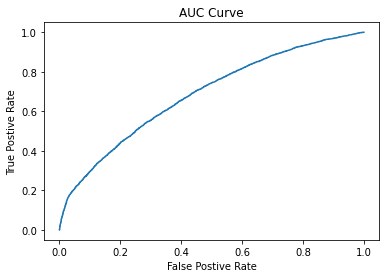

In [72]:
pos_probs=logreg.predict_proba(x_test_final)[::,1]
fpr,tpr,thresold=roc_curve(y_test,pos_probs)
plt.plot(fpr,tpr)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('AUC Curve')


In [73]:
roc_auc_score(y_test,pos_probs)

0.6843978943118938

In [74]:
# Decision Tree classsifie object creation
dtree=DecisionTreeClassifier()
dtree.fit(x_train_final,y_train)

DecisionTreeClassifier()

In [75]:
y_dtree_test_pred=dtree.predict(x_test_final)

In [76]:
confusion_matrix(y_test,y_dtree_test_pred)

array([[3173, 2496],
       [2366, 3317]], dtype=int64)

In [77]:
precision_score(y_test,y_dtree_test_pred)

0.5706175812833305

In [78]:
recall_score(y_test,y_dtree_test_pred)

0.5836705965159247

In [79]:
f1_score(y_test,y_dtree_test_pred)

0.577070285316632

Text(0.5, 1.0, 'AUC Curve of Dtree')

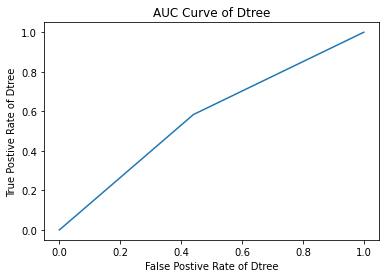

In [80]:
dtree_pos_probs=dtree.predict_proba(x_test_final)[::,1]
fpr_dtree,tpr_dtree,thresold_dtree=roc_curve(y_test,dtree_pos_probs)
plt.plot(fpr_dtree,tpr_dtree)
plt.xlabel('False Postive Rate of Dtree')
plt.ylabel('True Postive Rate of Dtree')
plt.title('AUC Curve of Dtree')


In [81]:
roc_auc_score(y_test,dtree_pos_probs)

0.5716906519358598

In [82]:
#Random forest classifier
rdfc=RandomForestClassifier(n_estimators=50,max_depth=10)
rdfc.fit(x_train_final,y_train)
rdfc_test_pred=rdfc.predict(x_test_final)

In [83]:
f1_score(y_test,rdfc_test_pred)

0.6305452666034973

In [84]:
# Adaptive boosting technique 
adbc=AdaBoostClassifier(n_estimators=50,learning_rate=1.5)
adbc.fit(x_train_final,y_train)
adbc_test_pred=adbc.predict(x_test_final)

In [85]:
f1_score(y_test,adbc_test_pred)

0.6335078534031413

In [86]:
rdfc_hp=RandomForestClassifier()

dict={
    'n_estimators': [10,20,30,40],
    'max_depth':[5,6,7,8,9],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[1,2,3,4]
    }

gvcv=GridSearchCV(rdfc,dict,cv=5)

In [ ]:
gvcv.fit(x_train_final,y_train) 